# Use BlackJAX with Numpyro

BlackJAX can take any log-probability function as long as it is compatible with JAX's JIT. In this notebook we show how we can use Numpyro as a modeling language and BlackJAX as an inference library.

We reproduce the Eight Schools example from the [Numpyro documentation](https://github.com/pyro-ppl/numpyro) (all credit for the model goes to the Numpyro team). For this notebook to run you will need to install Numpyro:

```bash
pip install numpyro
```

In [1]:
import jax
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.infer.util import initialize_model

import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup

## Data

In [2]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

## Model

We use the non-centered version of the model described towards the end of the README on Numpyro's repository:

In [3]:
# Eight Schools example - Non-centered Reparametrization
def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.HalfCauchy(5))
    with numpyro.plate("J", J):
        with numpyro.handlers.reparam(config={"theta": TransformReparam()}):
            theta = numpyro.sample(
                "theta",
                dist.TransformedDistribution(
                    dist.Normal(0.0, 1.0), dist.transforms.AffineTransform(mu, tau)
                ),
            )
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

We need to translate the model into a log-probability function that will be used by BlackJAX to perform inference. For that we use the `initialize_model` function in Numpyro's internals. We will also use the initial position it returns:

In [4]:
rng_key = jax.random.PRNGKey(0)

init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    eight_schools_noncentered,
    model_args=(J, sigma, y),
    dynamic_args=True,
)

Now we create the potential using the `potential_fn_gen` provided by Numpyro and initialize the NUTS state with BlackJAX:

In [5]:
logprob = lambda position: -potential_fn_gen(J, sigma, y)(position)
initial_position = init_params.z
initial_state = nuts.new_state(initial_position, logprob)

We now run the window adaptation in BlackJAX:

In [6]:
%%time

kernel_factory = lambda step_size, inverse_mass_matrix: nuts.kernel(
    logprob, step_size, inverse_mass_matrix
)

last_state, (step_size, inverse_mass_matrix), _ = stan_warmup.run(
    rng_key, kernel_factory, initial_state, 1000
)

CPU times: user 3.98 s, sys: 25.7 ms, total: 4 s
Wall time: 4 s


Let us now perform inference using the previously computed step size and inverse mass matrix. We also time the sampling to give you an idea of how fast BlackJAX can be on simple models:

In [7]:
%%time
from functools import partial


@partial(jax.jit, static_argnums=(1, 3))
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos


# Build the kernel using the step size and inverse mass matrix returned from the window adaptation
kernel = kernel_factory(step_size, inverse_mass_matrix)

# Sample from the posterior distribution
states, infos = inference_loop(rng_key, kernel, last_state, 100_000)
states.position["mu"].block_until_ready()

CPU times: user 2.37 s, sys: 19.5 ms, total: 2.39 s
Wall time: 2.38 s


DeviceArray([1.9602568 , 3.0159426 , 0.73644793, ..., 2.7515574 ,
             2.7098198 , 3.9557583 ], dtype=float32)

Let us compute the average acceptance probability and check the number of divergences (to make sure that the model sampled correctly, and that the sampling time is not a result of a majority of divergent transitions):

In [8]:
acceptance_rate = np.mean(infos.acceptance_probability)
num_divergent = np.mean(infos.is_divergent)
print(f"Acceptance rate: {acceptance_rate:.2f}")
print(f"% divergent transitions: {100*num_divergent:.2f}")

Acceptance rate: 0.70
% divergent transitions: 0.54


Let us now plot the distribution of the parameters. Note that since we use a transformed variable, Numpyro does not output the school treatment effect directly:

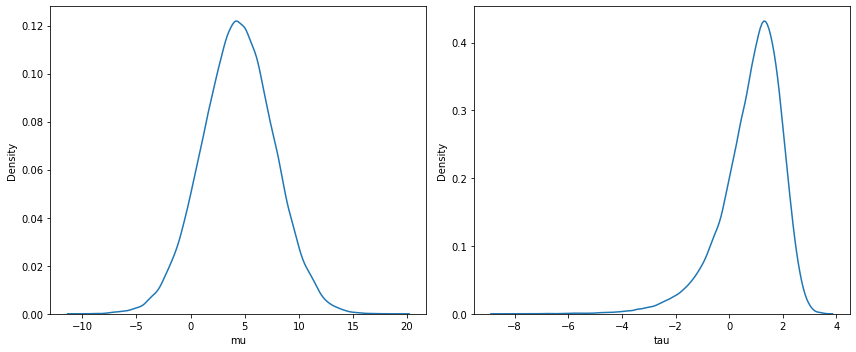

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

samples = states.position

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.kdeplot(samples["mu"], ax=axes[0])
sns.kdeplot(samples["tau"], ax=axes[1])
axes[0].set_xlabel("mu")
axes[1].set_xlabel("tau")
fig.tight_layout()

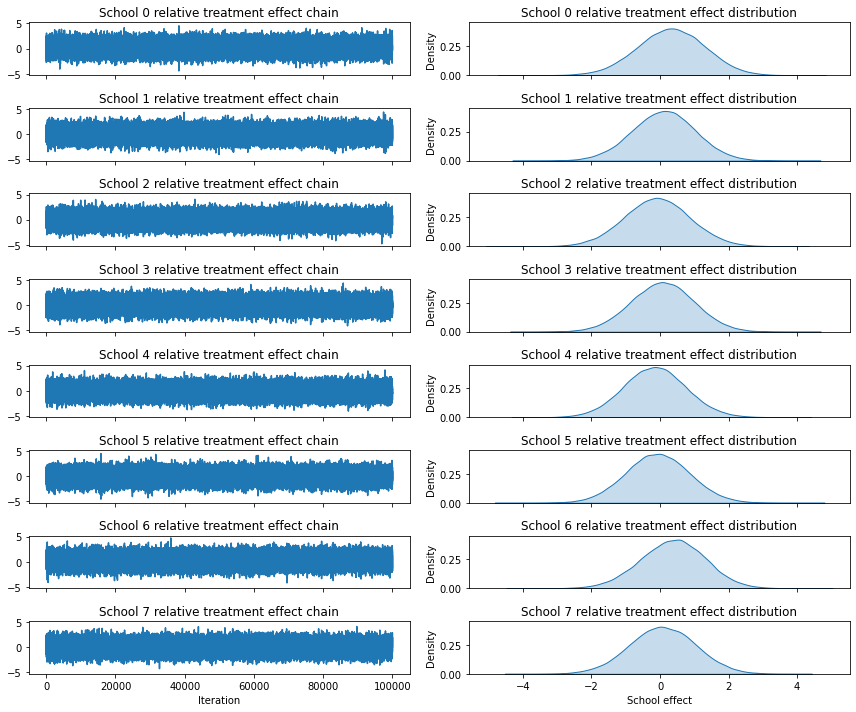

In [10]:
fig, axes = plt.subplots(8, 2, sharex="col", sharey="col")
fig.set_size_inches(12, 10)
for i in range(J):
    axes[i][0].plot(samples["theta_base"][:, i])
    axes[i][0].title.set_text(f"School {i} relative treatment effect chain")
    sns.kdeplot(samples["theta_base"][:, i], ax=axes[i][1], shade=True)
    axes[i][1].title.set_text(f"School {i} relative treatment effect distribution")
axes[J - 1][0].set_xlabel("Iteration")
axes[J - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [11]:
for i in range(J):
    print(
        f"Relative treatment effect for school {i}: {np.mean(samples['theta_base'][:, i]):.2f}"
    )

Relative treatment effect for school 0: 0.32
Relative treatment effect for school 1: 0.10
Relative treatment effect for school 2: -0.09
Relative treatment effect for school 3: 0.07
Relative treatment effect for school 4: -0.15
Relative treatment effect for school 5: -0.07
Relative treatment effect for school 6: 0.36
Relative treatment effect for school 7: 0.07


## Compare sampling time with Numpyro

We compare the time it took BlackJAX to do the warmup for 1,000 iterations and then taking 100,000 samples with Numpyro's:

In [12]:
from numpyro.infer import MCMC, NUTS

In [13]:
%%time

nuts_kernel = NUTS(eight_schools_noncentered)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=100_000, progress_bar=False)

rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y)
samples = mcmc.get_samples()

CPU times: user 2.86 s, sys: 38.3 ms, total: 2.9 s
Wall time: 2.87 s
